In [1]:
import sys
sys.path.append('/Users/jpnousu/pyAPES_main')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

import numpy as np
from pyAPES.utils.iotools import read_forcing
from pyAPES.soil.soil import Soil_1D
from pyAPES.canopy.forestfloor import ForestFloor
from pyAPES.parameters.mlm_parameters import gpara, cpara, spara # model configuration, canopy parameters, soil parameters
from pyAPES.utils.constants import WATER_DENSITY

import warnings
# Ignore FutureWarning messages globally
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
# Creating ForestFloor
forestfloor = ForestFloor(cpara['forestfloor'])

# Creating Soil_1D
soil = Soil_1D(spara)

# Manipulating the params to correspond to those of Degerö
gpara['forc_filename'] = r'/Users/jpnousu/pyAPES_main/forcing/Degero/Degero_forcing_2014-2016.dat'
gpara['start_time'] = '2014-09-01'
gpara['end_time'] = '2015-09-01'

In [3]:
# Reading the forcing file
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

forcing['Prec_liquid'] = forcing['Prec'].where(forcing['Tair'] > 1, 0)
forcing['Prec_ice'] = forcing['Prec'].where(forcing['Tair'] <= 1, 0)

In [4]:
# Looping over the forcing file, running forestfloor and soil models for each timestep and saving the results
results_df = pd.DataFrame()


# Number of soil layers
n_layers = len(soil.heat.T)  # or len(s_states['temperature']) at first timestep
# Number of timesteps
n_times = len(forcing)

# Initialize 2D array for soil temperatures
soil_temperatures = np.empty((n_layers, n_times))
snow_temperatures = np.empty((3, n_times))
snow_depths = np.empty((3, n_times))
soil_temperatures[:] = np.nan  # optional, initialize with NaN
snow_temperatures[:] = np.nan
snow_depths[:] = np.nan
t_idx = 0


for index, row in forcing.iterrows():

    ###### Inputs for forestfloor (based on how they are used in mlm_canopy.py)
    ff_forcing = {  # Reset the dictionary for each iteration
        'precipitation_rain': row['Prec_liquid'], # kg m-2 s-1
        'precipitation_snow': row['Prec_ice'], # kg m-2 s-1
        'wind_speed': row['U'], # m/s
        'par': row['diffPar'] + row['dirPar'],  # Total PAR [W m-2]
        'nir': row['diffNir'] + row['dirNir'],  # Total NIR [W m-2]
        'lw_dn': row['LWin'],  # Longwave downward radiation [W m-2]
        'h2o': row['H2O'] / 1000,  # H2O [mol mol-1]
        'co2': row['CO2'] * 1e6,  # Convert mol mol-1 to ppm
        'air_temperature': row['Tdaily'],  # Air temperature [degC]
        'air_pressure': row['P'],  # Air pressure [Pa]
        'soil_temperature': soil.heat.T[0], # Soil temperature [degC]
        'soil_water_potential': soil.water.h[0],
        'soil_volumetric_water': soil.heat.Wliq[0],
        'soil_volumetric_air': soil.heat.Wair[0],
        'soil_pond_storage': soil.water.h_pond
    }
    ff_params = {
        'soil_thermal_conductivity': soil.heat.thermal_conductivity[0],
        'soil_hydraulic_conductivity': soil.water.Kvsat[0],
        'soil_depth': soil.grid['dz'][0],
        'reference_height': 18.0,
    }
    ff_controls = {
        'energy_balance': True,
        'logger_info': 'test',
    }
    # --- solve forestfloor
    ff_fluxes, ff_states, gt_results = forestfloor.run(
                dt=gpara['dt'],
                forcing=ff_forcing,
                parameters=ff_params,
                controls=ff_controls
                )
    
    # --- update forestfloor
    forestfloor.update()

    ###### Inputs for soil (based on how they are used in pyAPES_MLM.py)
    s_forcing = {
        'potential_infiltration': ff_fluxes['throughfall'] / WATER_DENSITY,
        'potential_evaporation': (ff_fluxes['soil_evaporation'] + ff_fluxes['capillary_rise']) / WATER_DENSITY,
        'pond_recharge': ff_fluxes['pond_recharge'] / WATER_DENSITY,
        'atmospheric_pressure_head': -1.0E6, # [m]
        'ground_heat_flux': -ff_fluxes['ground_heat'],
        'date': index
    }
    
    s_fluxes, s_states = soil.run(
                dt=gpara['dt'],
                forcing=s_forcing,
                )
    
    # --- update soil
    s_states.update(s_fluxes)
    
    ###### Store soil temperatures in 2D array
    soil_temperatures[:, t_idx] = s_states['temperature']  # shape (n_layers,)
    snow_temperatures[:, t_idx] = ff_states['snow_temperature']  # shape (n_layers,)
    snow_depths[:, t_idx] = ff_states['snow_layer_depth']  # shape (n_layers,)

    t_idx += 1


    # Combine results into a single dictionary with all values as floats
    combined_results = {
        'time': index,  # Use the time index from the forcing DataFrame
        **{f'gt_{key}': value[0] for key, value in gt_results.items()}, 
        **{f'ff_{key}': value for key, value in ff_states.items()},
        **{f'ff_{key}': value for key, value in ff_fluxes.items()},
        **{f'soil_{key}': value.mean() if hasattr(value, 'mean') else value for key, value in s_states.items()},
    }

    # Append the combined results to the results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([combined_results])], ignore_index=True)

results_df.set_index('time', inplace=True)

results_df.loc[pd.isna(results_df['ff_snow_depth']), 'ff_snow_depth'] = 0.0

Text(0, 0.5, 'Temperature [C]')

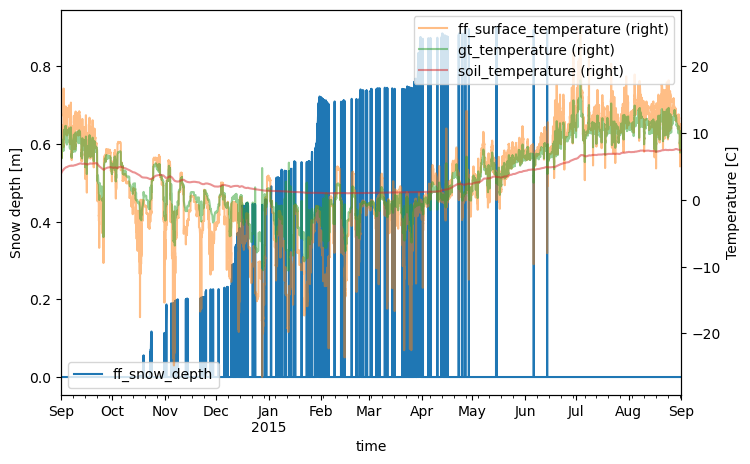

In [5]:
ax = results_df[['ff_snow_depth', 
            #'ff_snow_water_equivalent'
            ]].plot(figsize=(8, 5))

ax1 = results_df[['ff_surface_temperature',
                 'gt_temperature',
                 'soil_temperature']].plot(ax=ax, alpha=0.5, secondary_y=True)

ax.legend(loc='lower left')
ax1.legend(loc='upper right')
ax.set_ylabel('Snow depth [m]')
ax1.set_ylabel('Temperature [C]')
#filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/stability_2.png'
#plt.savefig(filename, dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Temperature [C]')

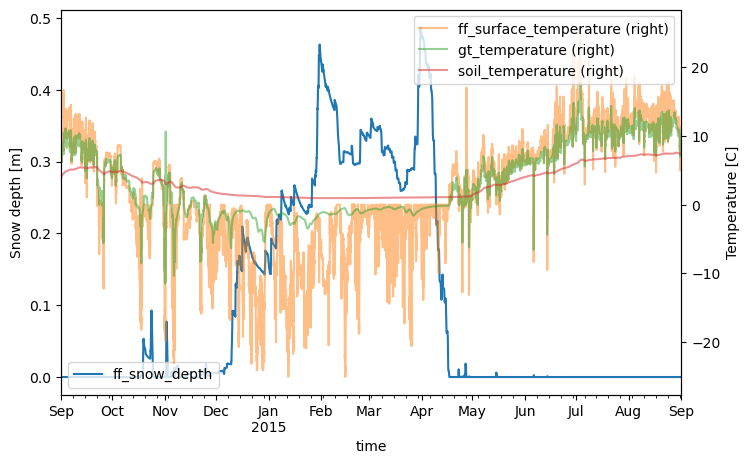

In [6]:
ax = results_df[['ff_snow_depth', 
            #'ff_snow_water_equivalent'
            ]].plot(figsize=(8, 5))

ax1 = results_df[['ff_surface_temperature',
                 'gt_temperature',
                 'soil_temperature']].plot(ax=ax, alpha=0.5, secondary_y=True)

ax.legend(loc='lower left')
ax1.legend(loc='upper right')
ax.set_ylabel('Snow depth [m]')
ax1.set_ylabel('Temperature [C]')
#filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/stability_2.png'
#plt.savefig(filename, dpi=300, bbox_inches="tight")


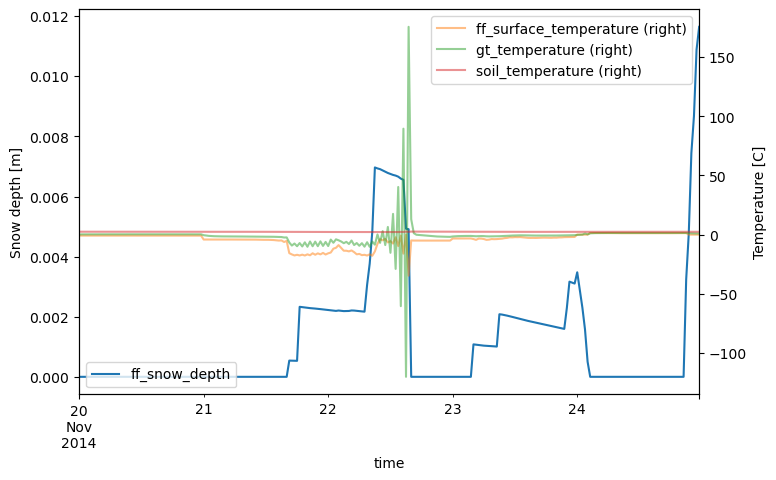

In [9]:
window = slice('2014-11-20', '2014-11-24')
ax = results_df[window][['ff_snow_depth', 
            #'ff_snow_water_equivalent'
            ]].plot(figsize=(8, 5))

ax1 = results_df[window][['ff_surface_temperature',
                 'gt_temperature',
                 'soil_temperature']].plot(ax=ax, alpha=0.5, secondary_y=True)

ax.legend(loc='lower left')
ax1.legend(loc='upper right')
ax.set_ylabel('Snow depth [m]')
ax1.set_ylabel('Temperature [C]')
#filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/stability_2_wd.png'
#plt.savefig(filename, dpi=300, bbox_inches="tight")


In [5]:
results_df_d = results_df.resample('D').mean()
results_df_d = results_df_d[:-1]
forcing = forcing.resample('D').mean()
forcing = forcing[:-1]

n_layers, n_time = soil_temperatures.shape
n_layers_snow, n_time = snow_temperatures.shape

n_steps_per_day = 48

# Make sure n_time is divisible by n_steps_per_day
n_days = n_time // n_steps_per_day
soil_temperatures_daily = soil_temperatures[:, :n_days * n_steps_per_day]  # trim extra
soil_temperatures_daily = soil_temperatures_daily.reshape(
    n_layers, n_days, n_steps_per_day
).mean(axis=2)  # mean over the 48 time steps

snow_temperatures_daily = snow_temperatures[:, :n_days * n_steps_per_day]  # trim extra
snow_temperatures_daily = snow_temperatures_daily.reshape(
    n_layers_snow, n_days, n_steps_per_day
).mean(axis=2)  # mean over the 48 time steps

snow_depths_daily = snow_depths[:, :n_days * n_steps_per_day]  # trim extra
snow_depths_daily = snow_depths_daily.reshape(
    n_layers_snow, n_days, n_steps_per_day
).mean(axis=2)  # mean over the 48 time steps

print(soil_temperatures_daily.shape)  # should be (44, n_days)
print(snow_temperatures_daily.shape)  # should be (44, n_days)
print(snow_depths_daily.shape)  # should be (44, n_days)
print(results_df_d.shape) 
# --- Replace soil_temperatures in your plotting code
soil_temperatures = soil_temperatures_daily
snow_temperatures = snow_temperatures_daily
snow_depths = snow_depths_daily

results_df = results_df_d

(44, 181)
(3, 181)
(3, 181)
(181, 75)


In [7]:
# Define ranges
times = len(results_df)
timestep = 1
snow_depth = max(results_df['ff_snow_depth'])
snow_step = 0.01
x = np.arange(0, times+timestep, timestep)    # 0 to 14000, step 1
y = np.arange(0, snow_depth+snow_step, snow_step)  # 0 to 0.5, step 0.01

# Create empty 2D array filled with np.nan
array_nan = np.full((len(y), len(x)), np.nan)

# Example arrays
# snow_depths: shape (3, time_steps) -> layers [top, middle, bottom] summed from bottom up
# snow_temperatures: shape (3, time_steps) -> temperatures for [top, middle, bottom] layers

# Your 2D grid
x = np.arange(0, snow_depths.shape[1])        # time axis
y = np.arange(0, 0.51, 0.01)                 # snow depth axis (0 to 0.5 m)
temp_grid = np.full((len(y), len(x)), np.nan)  # initialize 2D array with nan

# Loop over time to fill temperatures
for t in range(len(x)):
    # Calculate cumulative snow depth from bottom
    bottom = 0
    middle = snow_depths[2, t]                # bottom layer
    top = middle + snow_depths[1, t]          # middle layer
    total_top = top + snow_depths[0, t]       # top layer
    
    # Assign temperatures
    temp_grid[(y >= bottom) & (y < middle), t] = snow_temperatures[2, t]  # bottom temp
    temp_grid[(y >= middle) & (y < top), t] = snow_temperatures[1, t]     # middle temp
    temp_grid[(y >= top) & (y <= total_top), t] = snow_temperatures[0, t] # top temp

# Now temp_grid[y, x] contains temperatures at each snow depth and time


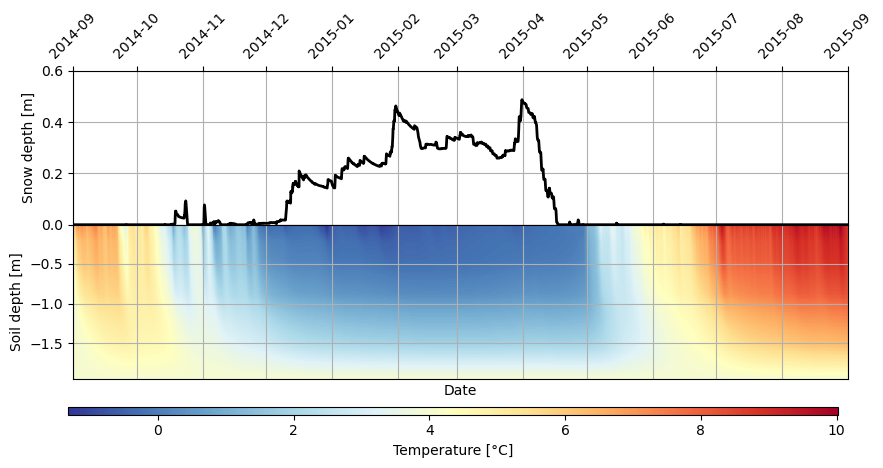

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Depths of soil layers
depths = soil.grid['z']

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 4), sharex=True,
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.0}
)

# --- Top plot: snow depth
ax1.plot(results_df.index, results_df['ff_snow_depth'], color='black', linewidth=2)
ax1.set_ylabel('Snow depth [m]')
ax1.grid(True)
ax1.set_ylim([0, 0.6])

# --- Move x-axis ticks and labels to top, monthly
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
months = mdates.MonthLocator()             # ticks every month
month_fmt = mdates.DateFormatter('%Y-%m')  # format as YYYY-MM
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(month_fmt)
ax1.tick_params(axis='x', rotation=45, labeltop=True, labelbottom=False)

# --- Bottom plot: soil temperature heatmap
im = ax2.imshow(
    soil_temperatures, cmap='RdYlBu_r', aspect='auto', origin='upper',
    extent=[mdates.date2num(results_df.index[0]),
            mdates.date2num(results_df.index[-1]),
            depths[-1], depths[0]]
)
ax2.set_ylabel('Soil depth [m]')
ax2.set_xlabel('Date')
ax2.grid(True)

# Hide bottom x-axis ticks since we show them on top
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Explicitly define colorbar position below the subplots
cbar_ax = fig.add_axes([0.12, 0.02, 0.77, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Temperature [°C]')
#filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/hs_st.png'
#plt.savefig(filename, dpi=300, bbox_inches="tight")

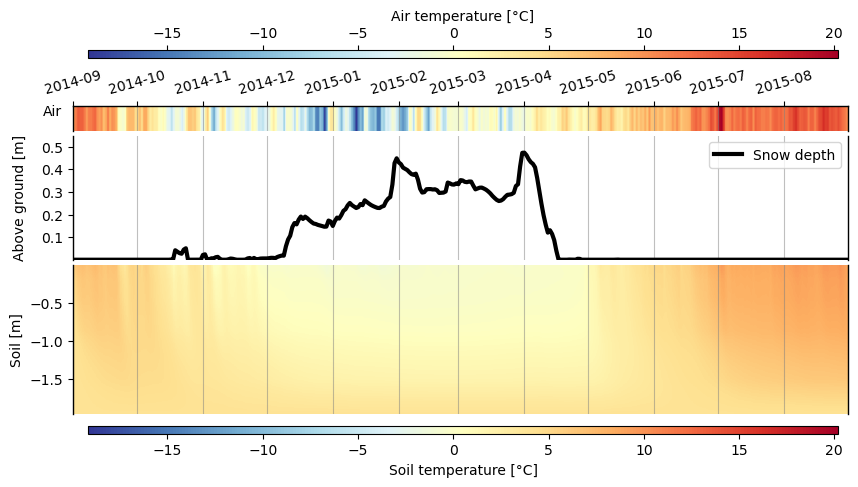

In [7]:
match_colorbar = True

# Depths of soil layers
depths = soil.grid['z']
cmap = 'RdYlBu_r'

# --- Determine separate vmin/vmax for air and soil temperatures
vmin_air, vmax_air = forcing['Tair'].min(), forcing['Tair'].max()
vmin_soil, vmax_soil = soil_temperatures.min(), soil_temperatures.max()

if match_colorbar:
    vmin_soil, vmax_soil = vmin_air, vmax_air
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_soil_match.png'
else:
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_soil.png'


fig, (ax_air, ax_snow, ax_soil) = plt.subplots(
    3, 1, figsize=(10, 4),
    gridspec_kw={'height_ratios': [0.2, 1.0, 1.2], 'hspace': 0.05}
)

# --- Common x-limits and tick locations
x_min = mdates.date2num(forcing.index[0])
x_max = mdates.date2num(forcing.index[-1])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%Y-%m')

# --- Top subplot: air temperature band
n_rows = 10
air_temp_array = np.tile(forcing['Tair'].values, (n_rows, 1))
im_air = ax_air.imshow(
    air_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_air, vmax=vmax_air
)
ax_air.set_yticks([])
ax_air.set_ylabel('Air', rotation=0, labelpad=15)
ax_air.grid(axis='x', color='gray', linestyle='-', alpha=0.5)

ax_air.set_xlim([x_min, x_max])
ax_air.xaxis.set_major_locator(months)
ax_air.xaxis.set_major_formatter(month_fmt)
ax_air.xaxis.set_label_position('top')
ax_air.xaxis.tick_top()
ax_air.tick_params(axis='x', rotation=15)

# --- Air temperature colorbar above the top subplot
cbar_air_ax = fig.add_axes([0.14, 1.0, 0.75, 0.02])  # [left, bottom, width, height]
cbar_air = fig.colorbar(im_air, cax=cbar_air_ax, orientation='horizontal')
cbar_air.set_label('Air temperature [°C]')
cbar_air.ax.xaxis.set_label_position('top')  # place label on top
cbar_air.ax.xaxis.set_ticks_position('top')   # move ticks above

# --- Middle subplot: snow depth
ax_snow.plot(results_df.index, results_df['ff_snow_depth'], color='black', linewidth=3, label='Snow depth')
ax_snow.set_ylabel('Above ground [m]', labelpad=10)
ax_snow.set_ylim([0, 0.55])
ax_snow.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_snow.set_xlim([x_min, x_max])
ax_snow.xaxis.set_major_locator(months)
ax_snow.tick_params(labelbottom=False)
ax_snow.legend()

# --- Bottom subplot: soil temperature heatmap
im_soil = ax_soil.imshow(
    soil_temperatures, cmap=cmap, aspect='auto', origin='upper',
    extent=[x_min, x_max, depths[-1], depths[0]],
    vmin=vmin_soil, vmax=vmax_soil
)
ax_soil.set_ylabel('Soil [m]')
ax_soil.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_soil.set_xlim([x_min, x_max])
ax_soil.xaxis.set_major_locator(months)
ax_soil.xaxis.set_major_formatter(month_fmt)
ax_soil.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Soil temperature colorbar below the figure
cbar_soil_ax = fig.add_axes([0.14, 0.06, 0.75, 0.02])
cbar_soil = fig.colorbar(im_soil, cax=cbar_soil_ax, orientation='horizontal')
cbar_soil.set_label('Soil temperature [°C]')

for i, ax in enumerate([ax_air, ax_snow, ax_soil]):
    # Keep left and right spines
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_linewidth(1.0)
    ax.spines['right'].set_color('black')
    
    # Top spine
    if i == 0:  # top subplot
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['top'].set_visible(False)
    
    # Bottom spine
    if i == 3:  # bottom subplot
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['bottom'].set_visible(False)
ax_snow.set_yticks(np.arange(0.1, 0.6, 0.1))
for ax in [ax_snow, ax_soil]:
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

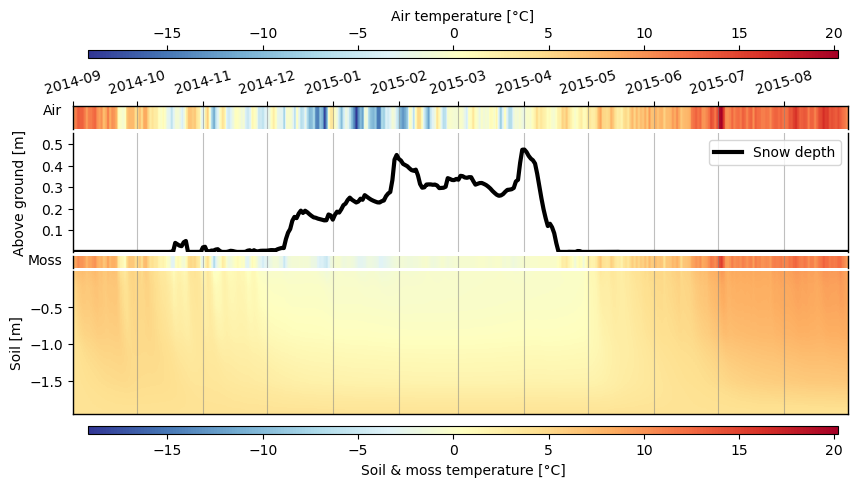

In [8]:
match_colorbar = True

# Depths of soil layers
depths = soil.grid['z']
cmap = 'RdYlBu_r'

# --- Determine separate vmin/vmax for air and soil/moss temperatures
vmin_air, vmax_air = forcing['Tair'].min(), forcing['Tair'].max()
vmin_moss_soil, vmax_moss_soil = results_df['gt_temperature'].min(), results_df['gt_temperature'].max()

if match_colorbar:
    vmin_moss_soil, vmax_moss_soil = vmin_air, vmax_air
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_moss_soil_match.png'
else:
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_moss_soil.png'

fig, (ax_air, ax_snow, ax_moss, ax_soil) = plt.subplots(
    4, 1, figsize=(10, 4),
    gridspec_kw={'height_ratios': [0.2, 1.0, 0.1, 1.2], 'hspace': 0.05}
)

# --- Common x-limits and tick locations
x_min = mdates.date2num(forcing.index[0])
x_max = mdates.date2num(forcing.index[-1])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%Y-%m')

# --- Top subplot: air temperature band
n_rows_air = 10
air_temp_array = np.tile(forcing['Tair'].values, (n_rows_air, 1))
im_air = ax_air.imshow(
    air_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_air, vmax=vmax_air
)
ax_air.set_yticks([])
ylab_air = ax_air.set_ylabel('Air', rotation=0, labelpad=15)
#ylab_air.set_position((ylab_air.get_position()[0], -0.01))  # adjust the second value
ax_air.grid(axis='x', color='gray', linestyle='-', alpha=0.5)

ax_air.set_xlim([x_min, x_max])
ax_air.xaxis.set_major_locator(months)
ax_air.xaxis.set_major_formatter(month_fmt)
ax_air.xaxis.set_label_position('top')
ax_air.xaxis.tick_top()
ax_air.tick_params(axis='x', rotation=15)

# --- Air temperature colorbar above the top subplot
cbar_air_ax = fig.add_axes([0.14, 1.0, 0.75, 0.02])
cbar_air = fig.colorbar(im_air, cax=cbar_air_ax, orientation='horizontal')
cbar_air.ax.xaxis.set_label_position('top')
cbar_air.ax.xaxis.set_ticks_position('top')
cbar_air.set_label('Air temperature [°C]')

# --- Middle-top subplot: snow depth
ax_snow.plot(results_df.index, results_df['ff_snow_depth'], color='black', linewidth=3, label='Snow depth')
ax_snow.set_ylabel('Above ground [m]', labelpad=10)
ax_snow.set_ylim([0.00001, 0.55])
ax_snow.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_snow.set_xlim([x_min, x_max])
ax_snow.xaxis.set_major_locator(months)
ax_snow.tick_params(labelbottom=False)
ax_snow.legend()

# --- Middle-bottom subplot: moss temperature band
n_rows_moss = 10
moss_temp_array = np.tile(results_df['gt_temperature'].values, (n_rows_moss, 1))
im_moss = ax_moss.imshow(
    moss_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_moss_soil, vmax=vmax_moss_soil
)
ax_moss.set_yticks([])
ylab_air  = ax_moss.set_ylabel('Moss', rotation=0, labelpad=20)
ylab_air.set_position((ylab_air.get_position()[0], -0.01))  # adjust the second value

# --- Align moss grid with snow and soil
ax_moss.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_moss.set_xlim([x_min, x_max])
ax_moss.xaxis.set_major_locator(months)
ax_moss.xaxis.set_major_formatter(month_fmt)
ax_moss.tick_params(labelbottom=False)

# --- Bottom subplot: soil temperature heatmap
im_soil = ax_soil.imshow(
    soil_temperatures, cmap=cmap, aspect='auto', origin='upper',
    extent=[x_min, x_max, depths[-1], depths[0]],
    vmin=vmin_moss_soil, vmax=vmax_moss_soil
)
ax_soil.set_ylabel('Soil [m]')
ax_soil.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_soil.set_xlim([x_min, x_max])
ax_soil.xaxis.set_major_locator(months)
ax_soil.xaxis.set_major_formatter(month_fmt)
ax_soil.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Soil/moss temperature colorbar below the figure
cbar_soil_ax = fig.add_axes([0.14, 0.06, 0.75, 0.02])
cbar_soil = fig.colorbar(im_soil, cax=cbar_soil_ax, orientation='horizontal')
cbar_soil.set_label('Soil & moss temperature [°C]')

for i, ax in enumerate([ax_air, ax_snow, ax_moss, ax_soil]):
    # Keep left and right spines
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_linewidth(1.0)
    ax.spines['right'].set_color('black')
    
    # Top spine
    if i == 0:  # top subplot
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['top'].set_visible(False)
    
    # Bottom spine
    if i == 3:  # bottom subplot
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['bottom'].set_visible(False)
ax_snow.set_yticks(np.arange(0.1, 0.6, 0.1))
for ax in [ax_snow, ax_moss, ax_soil]:
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

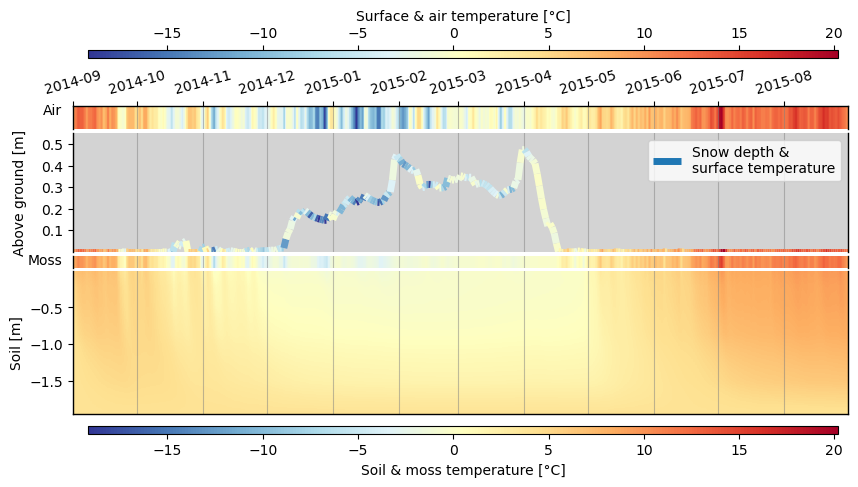

In [11]:
match_colorbar = True
# Depths of soil layers
depths = soil.grid['z']
cmap = 'RdYlBu_r'

# --- Determine separate vmin/vmax for air and soil/moss temperatures
vmin_air, vmax_air = forcing['Tair'].min(), forcing['Tair'].max()
vmin_moss_soil, vmax_moss_soil = results_df['gt_temperature'].min(), results_df['gt_temperature'].max()
if match_colorbar:
    vmin_moss_soil, vmax_moss_soil = vmin_air, vmax_air
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_snow_moss_soil_match.png'
else:
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_snow_moss_soil.png'

fig, (ax_air, ax_snow, ax_moss, ax_soil) = plt.subplots(
    4, 1, figsize=(10, 4),
    gridspec_kw={'height_ratios': [0.2, 1.0, 0.1, 1.2], 'hspace': 0.05}
)

# --- Common x-limits and tick locations
x_min = mdates.date2num(forcing.index[0])
x_max = mdates.date2num(forcing.index[-1])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%Y-%m')

# --- Top subplot: air temperature band
n_rows_air = 10
air_temp_array = np.tile(forcing['Tair'].values, (n_rows_air, 1))
im_air = ax_air.imshow(
    air_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_air, vmax=vmax_air
)
ax_air.set_yticks([])
ylab_air = ax_air.set_ylabel('Air', rotation=0, labelpad=15)
#ylab_air.set_position((ylab_air.get_position()[0], -0.001))  # adjust the second value
ax_air.grid(axis='x', color='gray', linestyle='-', alpha=0.5)

ax_air.set_xlim([x_min, x_max])
ax_air.xaxis.set_major_locator(months)
ax_air.xaxis.set_major_formatter(month_fmt)
ax_air.xaxis.set_label_position('top')
ax_air.xaxis.tick_top()
ax_air.tick_params(axis='x', rotation=15)

# --- Air temperature colorbar above the top subplot
cbar_air_ax = fig.add_axes([0.14, 1.0, 0.75, 0.02])
cbar_air = fig.colorbar(im_air, cax=cbar_air_ax, orientation='horizontal')
cbar_air.ax.xaxis.set_label_position('top')
cbar_air.ax.xaxis.set_ticks_position('top')
cbar_air.set_label('Surface & air temperature [°C]')

# --- Middle-top subplot: snow depth with surface temperature colors
x = mdates.date2num(results_df.index)
y = results_df['ff_snow_depth'].values
temps = results_df['ff_surface_temperature'].values  # surface temp for coloring

# Create segments for LineCollection
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(
    segments, cmap=cmap,
    norm=plt.Normalize(vmin=vmin_air, vmax=vmax_air)
)
lc.set_array(temps)
lc.set_linewidth(5)

ax_snow.add_collection(lc)
ax_snow.set_ylabel('Above ground [m]', labelpad=10)
ax_snow.set_ylim([0.0, 0.55])
ax_snow.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_snow.set_xlim([x_min, x_max])
ax_snow.xaxis.set_major_locator(months)
ax_snow.tick_params(labelbottom=False)
ax_snow.legend([lc], ['Snow depth &\nsurface temperature'], loc='upper right')

# --- Middle-bottom subplot: moss temperature band
n_rows_moss = 10
moss_temp_array = np.tile(results_df['gt_temperature'].values, (n_rows_moss, 1))
im_moss = ax_moss.imshow(
    moss_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_moss_soil, vmax=vmax_moss_soil
)
ax_moss.set_yticks([])
ylab_air  = ax_moss.set_ylabel('Moss', rotation=0, labelpad=20
                            )
ylab_air.set_position((ylab_air.get_position()[0], -0.01))

# --- Align moss grid with snow and soil
ax_moss.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_moss.set_xlim([x_min, x_max])
ax_moss.xaxis.set_major_locator(months)
ax_moss.xaxis.set_major_formatter(month_fmt)
ax_moss.tick_params(labelbottom=False)

# --- Bottom subplot: soil temperature heatmap
im_soil = ax_soil.imshow(
    soil_temperatures, cmap=cmap, aspect='auto', origin='upper',
    extent=[x_min, x_max, depths[-1], depths[0]],
    vmin=vmin_moss_soil, vmax=vmax_moss_soil
)
ax_soil.set_ylabel('Soil [m]')
ax_soil.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_soil.set_xlim([x_min, x_max])
ax_soil.xaxis.set_major_locator(months)
ax_soil.xaxis.set_major_formatter(month_fmt)
ax_soil.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Soil/moss temperature colorbar below the figure
cbar_soil_ax = fig.add_axes([0.14, 0.06, 0.75, 0.02])
cbar_soil = fig.colorbar(im_soil, cax=cbar_soil_ax, orientation='horizontal')
cbar_soil.set_label('Soil & moss temperature [°C]')

# --- Spine adjustments (borders)

for i, ax in enumerate([ax_air, ax_snow, ax_moss, ax_soil]):
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_linewidth(1.0)
    ax.spines['right'].set_color('black')
    
    if i == 0:  # top subplot
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['top'].set_visible(False)
    
    if i == 3:  # bottom subplot
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['bottom'].set_visible(False)
    ax.set_facecolor("lightgrey")

ax_snow.set_yticks(np.arange(0.1, 0.6, 0.1))
for ax in [ax_snow, ax_moss, ax_soil]:
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()


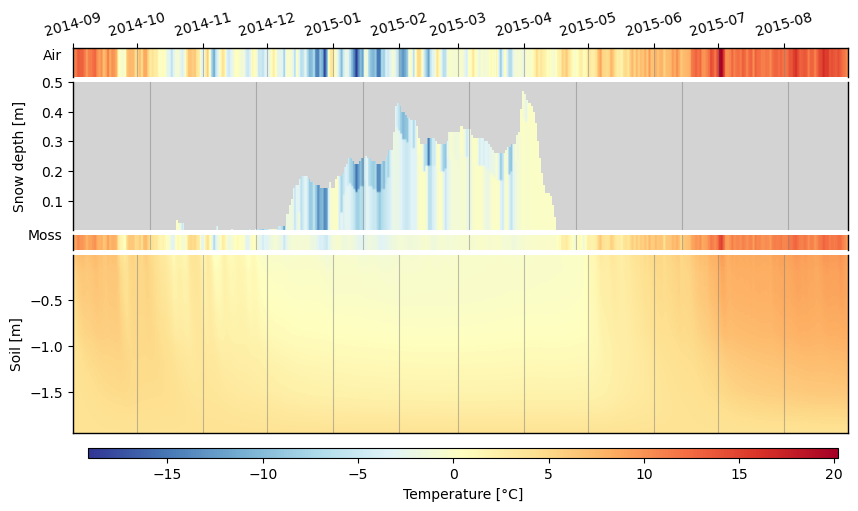

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# --- Settings
match_colorbar = True
cmap = 'RdYlBu_r'

# Depths of soil layers
depths = soil.grid['z']

# Determine color scales
vmin_air, vmax_air = forcing['Tair'].min(), forcing['Tair'].max()
vmin_moss_soil, vmax_moss_soil = results_df['gt_temperature'].min(), results_df['gt_temperature'].max()
if match_colorbar:
    vmin_moss_soil, vmax_moss_soil = vmin_air, vmax_air
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_snowl_moss_soil_match.png'
else:
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_snowl_moss_soil.png'

# --- Figure and subplots
fig, (ax_air, ax_snow, ax_moss, ax_soil) = plt.subplots(
    4, 1, figsize=(10, 5),
    gridspec_kw={'height_ratios': [0.2, 1.0, 0.1, 1.2], 'hspace': 0.05}
)

# --- Common x-axis info
x_min = mdates.date2num(forcing.index[0])
x_max = mdates.date2num(forcing.index[-1])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%Y-%m')

# --- Top subplot: air temperature band
n_rows_air = 10
air_temp_array = np.tile(forcing['Tair'].values, (n_rows_air, 1))
im_air = ax_air.imshow(
    air_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_air, vmax=vmax_air
)
ax_air.set_yticks([])
ax_air.set_ylabel('Air', rotation=0, labelpad=15)
ax_air.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_air.set_xlim([x_min, x_max])
ax_air.xaxis.set_major_locator(months)
ax_air.xaxis.set_major_formatter(month_fmt)
ax_air.xaxis.set_label_position('top')
ax_air.xaxis.tick_top()
ax_air.tick_params(axis='x', rotation=15)

# --- Air temperature colorbar above the top subplot
cbar_air_ax = fig.add_axes([0.14, 1.0, 0.75, 0.02])
cbar_air = fig.colorbar(im_air, cax=cbar_air_ax, orientation='horizontal')
cbar_air.ax.xaxis.set_label_position('top')
cbar_air.ax.xaxis.set_ticks_position('top')
cbar_air.set_label('Snow & air temperature [°C]')

# --- Second subplot: snow temperature heatmap
time_nums = mdates.date2num(results_df.index)

im_snow = ax_snow.imshow(
    temp_grid,  # only snow layers
    cmap=cmap,
    aspect='auto',
    origin='lower',
    extent=[x_min, x_max, 0, 0.5],
    vmin=vmin_air,
    vmax=vmax_air
)
ax_snow.set_ylabel('Snow depth [m]', labelpad=10)
ax_snow.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_snow.set_xlim([x_min, x_max])
ax_snow.tick_params(labelbottom=False)

# Optional: overlay thin lines for snow layer boundaries (can be kept or removed)
bottom_layer = snow_depths[2, :]
middle_layer = bottom_layer + snow_depths[1, :]
top_layer = middle_layer + snow_depths[0, :]
# ax_snow.plot(time_nums, bottom_layer, color='k', linewidth=0.5, alpha=0.5)
# ax_snow.plot(time_nums, middle_layer, color='k', linewidth=0.5, alpha=0.5)
# ax_snow.plot(time_nums, top_layer, color='k', linewidth=0.5, alpha=0.5)

# --- Third subplot: moss temperature band
n_rows_moss = 10
moss_temp_array = np.tile(results_df['gt_temperature'].values, (n_rows_moss, 1))
im_moss = ax_moss.imshow(
    moss_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_moss_soil, vmax=vmax_moss_soil
)
ax_moss.set_yticks([])
ax_moss.set_ylabel('Moss', rotation=0, labelpad=20)
ax_moss.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_moss.set_xlim([x_min, x_max])
ax_moss.tick_params(labelbottom=False)

# --- Bottom subplot: soil temperature heatmap
im_soil = ax_soil.imshow(
    soil_temperatures, cmap=cmap, aspect='auto', origin='upper',
    extent=[x_min, x_max, depths[-1], depths[0]],
    vmin=vmin_moss_soil, vmax=vmax_moss_soil
)
ax_soil.set_ylabel('Soil [m]')
ax_soil.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_soil.set_xlim([x_min, x_max])
ax_soil.xaxis.set_major_locator(months)
ax_soil.xaxis.set_major_formatter(month_fmt)
ax_soil.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Soil/moss temperature colorbar below the figure
cbar_soil_ax = fig.add_axes([0.14, 0.06, 0.75, 0.02])
cbar_soil = fig.colorbar(im_soil, cax=cbar_soil_ax, orientation='horizontal')
cbar_soil.set_label('Soil & moss temperature [°C]')

# --- Colorbar (single, if match_colorbar)
if match_colorbar:
    # Remove existing colorbars if they were already created
    for cbar in [cbar_air_ax, cbar_soil_ax]:
        cbar.remove() if 'cbar' in locals() else None  # just in case
    cbar_ax = fig.add_axes([0.14, 0.06, 0.75, 0.02])
    cbar = fig.colorbar(im_soil, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Temperature [°C]')
else:
    # Individual colorbars for air and soil/moss if needed
    pass

# --- Spine adjustments and background
for i, ax in enumerate([ax_air, ax_snow, ax_moss, ax_soil]):
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_linewidth(1.0)
    ax.spines['right'].set_color('black')
    
    if i == 0:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['top'].set_visible(False)
    
    if i == 3:
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['bottom'].set_visible(False)
    ax.set_facecolor("lightgrey")

# --- Y-ticks for snow
ax_snow.set_yticks(np.arange(0.1, 0.55, 0.1))
for ax in [ax_snow, ax_moss, ax_soil]:
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Save and show
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()


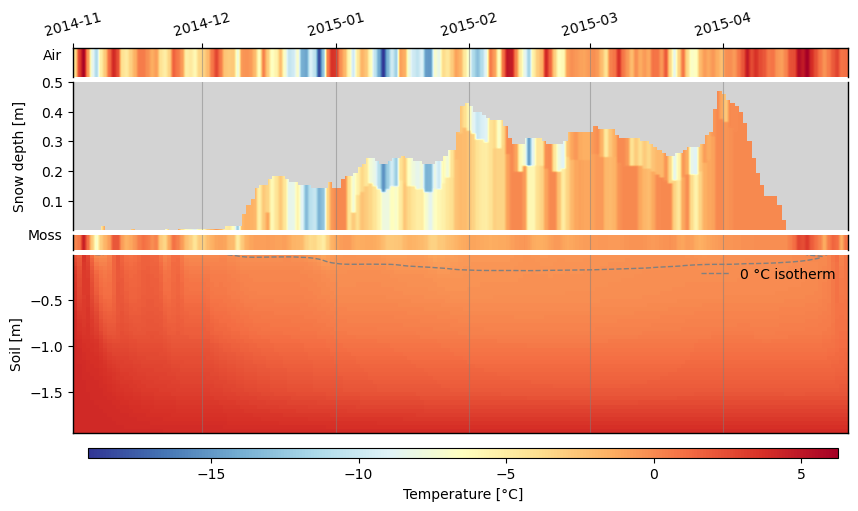

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# --- Settings
match_colorbar = True
cmap = 'RdYlBu_r'

# Depths of soil layers
depths = soil.grid['z']

# Determine color scales
vmin_air, vmax_air = forcing['Tair'].min(), forcing['Tair'].max()
vmin_moss_soil, vmax_moss_soil = results_df['gt_temperature'].min(), results_df['gt_temperature'].max()
if match_colorbar:
    vmin_moss_soil, vmax_moss_soil = vmin_air, vmax_air
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_snowl_moss_soil_match.png'
else:
    filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/tair_snowl_moss_soil.png'

# --- Figure and subplots
fig, (ax_air, ax_snow, ax_moss, ax_soil) = plt.subplots(
    4, 1, figsize=(10, 5),
    gridspec_kw={'height_ratios': [0.2, 1.0, 0.1, 1.2], 'hspace': 0.05}
)

# --- Common x-axis info
x_min = mdates.date2num(forcing.index[0])
x_max = mdates.date2num(forcing.index[-1])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%Y-%m')

# --- Top subplot: air temperature band
n_rows_air = 10
air_temp_array = np.tile(forcing['Tair'].values, (n_rows_air, 1))
im_air = ax_air.imshow(
    air_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_air, vmax=vmax_air
)
ax_air.set_yticks([])
ax_air.set_ylabel('Air', rotation=0, labelpad=15)
ax_air.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_air.set_xlim([x_min, x_max])
ax_air.xaxis.set_major_locator(months)
ax_air.xaxis.set_major_formatter(month_fmt)
ax_air.xaxis.set_label_position('top')
ax_air.xaxis.tick_top()
ax_air.tick_params(axis='x', rotation=15)

# --- Second subplot: snow temperature heatmap
time_nums = mdates.date2num(results_df.index)
im_snow = ax_snow.imshow(
    temp_grid,  # only snow layers
    cmap=cmap,
    aspect='auto',
    origin='lower',
    extent=[x_min, x_max, 0, 0.5],
    vmin=vmin_air,
    vmax=vmax_air
)
ax_snow.set_ylabel('Snow depth [m]', labelpad=10)
ax_snow.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_snow.set_xlim([x_min, x_max])
ax_snow.tick_params(labelbottom=False)

# --- Make snow x-axis consistent with other panels
ax_snow.set_xlim([x_min, x_max])
ax_snow.xaxis.set_major_locator(months)
ax_snow.xaxis.set_major_formatter(month_fmt)
ax_snow.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_snow.tick_params(labelbottom=False)  # hide labels, keep grid

# Optional: overlay thin lines for snow layer boundaries (commented out)
# bottom_layer = snow_depths[2, :]
# middle_layer = bottom_layer + snow_depths[1, :]
# top_layer = middle_layer + snow_depths[0, :]
# ax_snow.plot(time_nums, bottom_layer, color='k', linewidth=0.5, alpha=0.5)
# ax_snow.plot(time_nums, middle_layer, color='k', linewidth=0.5, alpha=0.5)
# ax_snow.plot(time_nums, top_layer, color='k', linewidth=0.5, alpha=0.5)

# --- Third subplot: moss temperature band
n_rows_moss = 10
moss_temp_array = np.tile(results_df['gt_temperature'].values, (n_rows_moss, 1))
im_moss = ax_moss.imshow(
    moss_temp_array, aspect='auto', origin='lower',
    extent=[x_min, x_max, 0, 1],
    cmap=cmap, vmin=vmin_moss_soil, vmax=vmax_moss_soil
)

# --- Make moss x-axis consistent with other panels
ax_moss.set_xlim([x_min, x_max])
ax_moss.xaxis.set_major_locator(months)
ax_moss.xaxis.set_major_formatter(month_fmt)
ax_moss.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_moss.tick_params(labelbottom=False)  # hide labels but keep grid

ax_moss.set_yticks([])
ax_moss.set_ylabel('Moss', rotation=0, labelpad=20)
ax_moss.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_moss.set_xlim([x_min, x_max])
ax_moss.tick_params(labelbottom=False)

# --- Bottom subplot: soil temperature heatmap
im_soil = ax_soil.imshow(
    soil_temperatures, cmap=cmap, aspect='auto', origin='upper',
    extent=[x_min, x_max, depths[-1], depths[0]],
    vmin=vmin_moss_soil, vmax=vmax_moss_soil
)
ax_soil.set_ylabel('Soil [m]')
ax_soil.grid(axis='x', color='gray', linestyle='-', alpha=0.5)
ax_soil.set_xlim([x_min, x_max])
ax_soil.xaxis.set_major_locator(months)
ax_soil.xaxis.set_major_formatter(month_fmt)
ax_soil.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Overlay 0°C contour on soil only
ax_soil.contour(
    time_nums, depths, soil_temperatures,
    levels=[0],
    colors='grey', linewidths=1.0, linestyles='--'
)

# --- Add proxy line for legend
contour_proxy = Line2D([0], [0], color='grey', linewidth=1.0, linestyle='--')
ax_soil.legend([contour_proxy], ['0 °C isotherm'], loc='upper right', frameon=False)

# --- Colorbars
if match_colorbar:
    # Single colorbar below all subplots
    cbar_ax = fig.add_axes([0.14, 0.06, 0.75, 0.02])
    cbar = fig.colorbar(im_soil, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Temperature [°C]')
else:
    # Air colorbar
    cbar_air_ax = fig.add_axes([0.14, 1.0, 0.75, 0.02])
    cbar_air = fig.colorbar(im_air, cax=cbar_air_ax, orientation='horizontal')
    cbar_air.ax.xaxis.set_label_position('top')
    cbar_air.ax.xaxis.set_ticks_position('top')
    cbar_air.set_label('Snow & air temperature [°C]')
    
    # Soil/moss colorbar
    cbar_soil_ax = fig.add_axes([0.14, 0.06, 0.75, 0.02])
    cbar_soil = fig.colorbar(im_soil, cax=cbar_soil_ax, orientation='horizontal')
    cbar_soil.set_label('Soil & moss temperature [°C]')

# --- Spine adjustments and background
for i, ax in enumerate([ax_air, ax_snow, ax_moss, ax_soil]):
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_linewidth(1.0)
    ax.spines['right'].set_color('black')
    
    if i == 0:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['top'].set_visible(False)
    
    if i == 3:
        ax.spines['bottom'].set_linewidth(1.0)
        ax.spines['bottom'].set_color('black')
    else:
        ax.spines['bottom'].set_visible(False)
    ax.set_facecolor("lightgrey")

# --- Y-ticks for snow
ax_snow.set_yticks(np.arange(0.1, 0.55, 0.1))
for ax in [ax_snow, ax_moss, ax_soil]:
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Save and show
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()
